In [27]:
import pandas as pd
from plotnine import *
from geopandas import GeoDataFrame

Import Kyiv boundaries as GeoJSON (rendered via https://overpass-turbo.eu/)

In [28]:
import geopandas
import folium
from shapely.geometry import shape

# read geojson
places = geopandas.read_file('kyiv.geojson')
kyiv_boundary = places[places.place.eq('city')]

Import roads for Ukraine from OSM that are downloaded from here: http://www.geofabrik.de/data/shapefiles.html

In [29]:
shp_path = 'gis_osm_roads_free_1.shp'
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads.head()

osm_id  code       fclass                          name   ref oneway  \
0  4319972  5122  residential          Володимирська вулиця  None      B   
1  4319974  5113      primary  Набережно-Хрещатицька вулиця  None      F   
2  4327781  5115     tertiary             Ревуцького вулиця  None      F   
3  4327811  5114    secondary             Зої Гайдай вулиця  None      F   
4  4327812  5114    secondary             Йорданська вулиця  None      F   

   maxspeed  layer bridge tunnel  \
0        50      0      F      F   
1        40      0      F      F   
2         0      0      F      F   
3        50      0      F      F   
4        50      0      F      F   

                                            geometry  
0  LINESTRING (30.51809 50.45791, 30.51806 50.457...  
1  LINESTRING (30.52383 50.46943, 30.52389 50.469...  
2  LINESTRING (30.64523 50.41266, 30.64531 50.412...  
3  LINESTRING (30.49431 50.51264, 30.49411 50.512...  
4  LINESTRING (30.50752 50.48888, 30.50731 50.489...

Filter roads from all over Ukraine to Kyiv roads only using approximation.

In [58]:
from shapely import Polygon
from shapely.ops import transform

# approximation
left = 100
right = 0
top = 0
bottom = 100

for el in kyiv_boundary.geometry[0].exterior.coords:
    left = min(left, el[0])
    right = max(right, el[0])
    bottom = min(bottom, el[1])
    top = max(top, el[1])

kyiv_square_polygon = Polygon([[top, left], [top, right], [bottom, right],[bottom, left]])
kyiv_square_polygon_rotated = transform(lambda x, y, z=None: (y,x), kyiv_square_polygon)

kyiv_roads = roads.loc[roads['geometry'].apply(lambda g: kyiv_square_polygon_rotated.contains(g))].copy()

kyiv_roads.shape

(126401, 11)

Get streets from file.

In [31]:
f = open('renamed_streets', 'r', encoding='utf-8')
street_names = []
street_type = ['шосе', 'бульвар', 'вулиця', 'площа', 'провулок', 'проспект', 'тупик', 'узвіз']
street_dict = {}
state = '2022'
full_street_dict = []
for l in f.readlines():
    if '>' in l:
        old_name = l.split('>')[0].strip()
        new_name = l.split('>')[1].strip()
        street_type_name = ''.join([(el if el in old_name else '') for el in street_type])
        new_street_type_name = ''.join([(el if el in new_name else '') for el in street_type])
        if street_type_name == 'шосевулиця':
            street_type_name = 'вулиця'
        old_name = old_name.replace(street_type_name, '').strip() + ' ' + street_type_name
        if street_type_name == new_street_type_name:
            new_name = new_name.replace(street_type_name, '').strip() + ' ' + street_type_name
        else:
            new_name = new_name.replace(new_street_type_name, '').strip() + ' ' + new_street_type_name
        street_names.extend([old_name, new_name])
        full_street_dict.append((old_name, new_name))
        if state == '2022':
            street_dict[old_name] = '2022'
            street_dict[new_name] = '2022'
        else:
            street_dict[old_name] = '2014'
            street_dict[new_name] = '2014'
    else:
        if l.strip() == '2022':
            state = '2022'
        else:
            state = '2014'



Filter streets.

In [56]:
kyiv_roads_filtered = kyiv_roads[kyiv_roads.name.isin(street_names)]
kyiv_roads_filtered = kyiv_roads_filtered.loc[kyiv_roads_filtered['geometry'].apply(lambda g: kyiv_boundary.geometry[0].contains(g))]
kyiv_roads_filtered.shape

(1840, 11)

Map using Folium.

In [80]:
x, y = kyiv_square_polygon.centroid.coords.xy
# kyiv_map = folium.Map(location=[x[0], y[0]], zoom_start=10, tiles='CartoDB positron')
kyiv_map = folium.Map(location=[x[0], y[0]], tiles=None)
folium.GeoJson(kyiv_boundary.to_json(), style_function = lambda x: {"fillOpacity": "0", "weight": "0.5", "color": "#40798C"}).add_to(kyiv_map)
added_streets = set()
for _, r in kyiv_roads_filtered.iterrows():
    r2 = transform(lambda x, y, z=None: (y,x), r.geometry)
    if street_dict[r['name']] == '2022':
        folium.PolyLine(r2.coords, color='#E8AE68', weight='2.25').add_to(kyiv_map)
    else:
        folium.PolyLine(r2.coords, color='#EF5D60', weight='2.25').add_to(kyiv_map)
    added_streets.add(r['name'])

# other roads
for _, r in kyiv_roads[kyiv_roads.fclass.isin(['trunk', 'primary']) | kyiv_roads['name'].notnull()].iterrows():
    r2 = transform(lambda x, y, z=None: (y,x), r.geometry)
    if not (r['name'] in added_streets) and kyiv_boundary.geometry[0].contains(r.geometry):
        folium.PolyLine(r2.coords, color='#40798C', weight='0.5').add_to(kyiv_map)

kyiv_map.fit_bounds(kyiv_map.get_bounds(), padding=(10,10))

# kyiv_map


Check missed object names.

In [250]:
shown_roads = set()
for _, r in kyiv_roads_filtered.iterrows():
    r2 = transform(lambda x, y, z=None: (y,x), r.geometry)
    if kyiv_boundary.geometry[0].contains(r.geometry):
        shown_roads.add(r['name'])
missed_streets = []
for el in full_street_dict:
    if el[0] in shown_roads or el[1] in shown_roads:
        1
    else:
        missed_streets.append(el)

In [251]:
len(missed_streets)
missed_streets

[('Червоноармійський 2 провулок', 'Щасливий провулок'),
 ('Червоноармійський 3 провулок', 'Радісний провулок'),
 ('Павла Вірського вулиця', 'Анатолія Авдієвського вулиця'),
 ('Олександра Бойченка вулиця', 'Анатолія Солов’яненка вулиця'),
 ('Івана Федька провулок', 'Якова Шульгина провулок'),
 ('Радгосп «Совки» вулиця', 'Пронівська вулиця'),
 ('Дежнєва провулок', 'Сіверсько-Донецький провулок'),
 ('Тульська площа', 'Героїв УПА площа'),
 ('Героїв Великої Вітчизняної війни площа', 'Наводницька площа'),
 ('Червона Пресня площа', 'Щекавицька площа'),
 ('Смирнова-Ласточкіна вулиця', 'Вознесенський узвіз ')]

In [75]:
len(added_streets), len([k for k, v in street_dict.items() if v == '2022'])/2, len([k for k, v in street_dict.items() if v != '2022'])/2

(437, 181.0, 238.0)

In [18]:
all_streets = set()

for _, r in kyiv_roads.iterrows():
    r2 = transform(lambda x, y, z=None: (y,x), r.geometry)
    if kyiv_boundary.geometry[0].contains(r.geometry):
        all_streets.add(r['name'])

len(all_streets)

2528

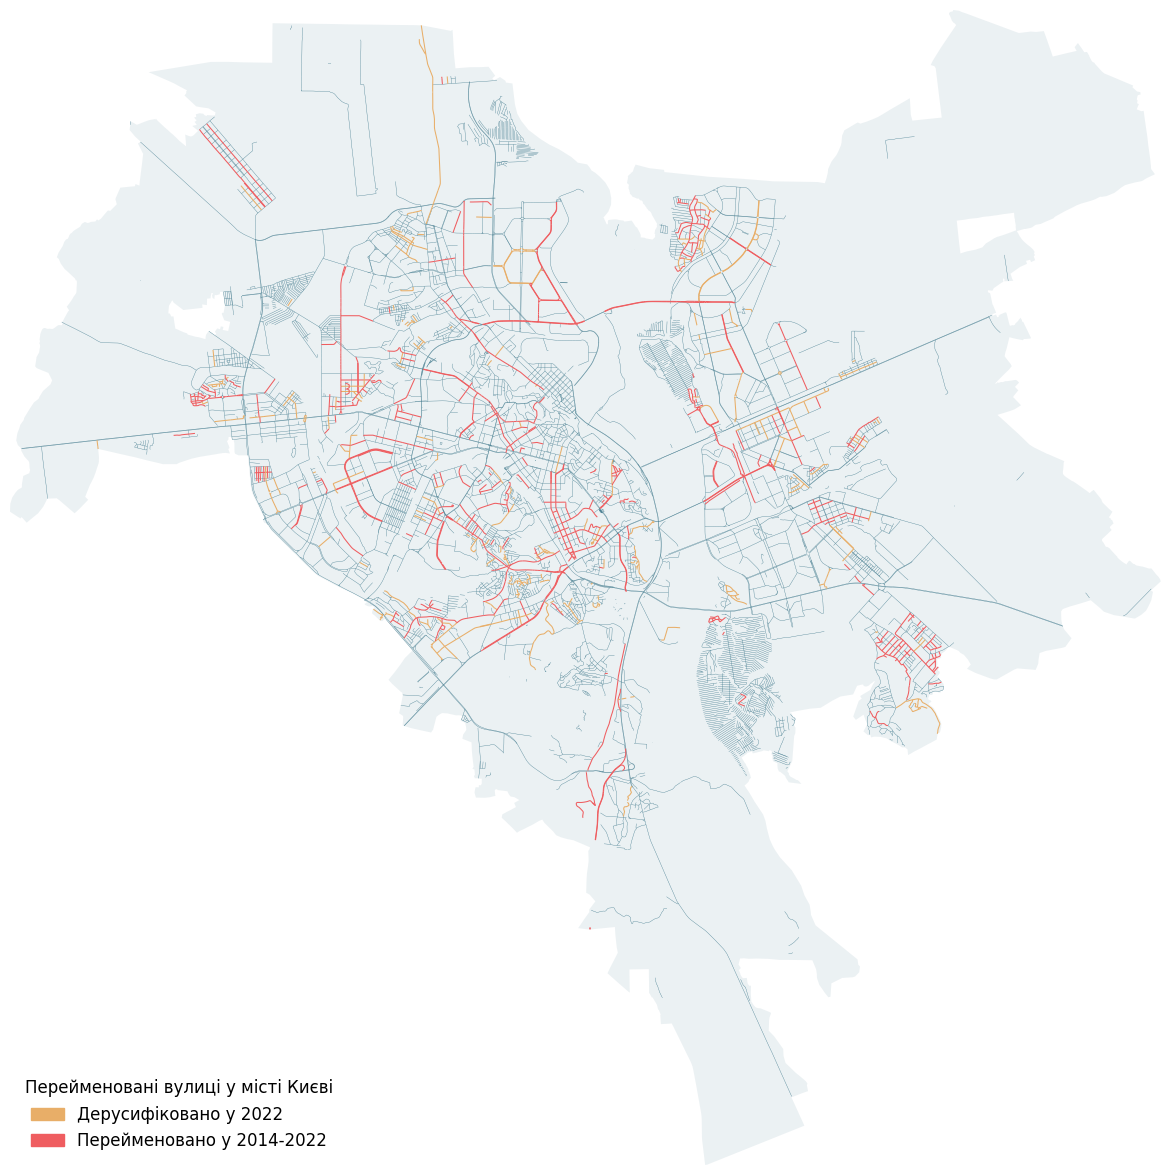

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
    
f, ax = plt.subplots(1, figsize=(15, 15))

key_kyiv_roads = kyiv_roads[kyiv_roads.fclass.isin(['trunk', 'primary']) | kyiv_roads['name'].notnull()]
key_kyiv_roads = key_kyiv_roads.loc[key_kyiv_roads['geometry'].apply(lambda g: kyiv_boundary.geometry[0].contains(g))]
key_kyiv_roads = key_kyiv_roads[key_kyiv_roads.name.apply(lambda el: not el in added_streets)]
key_kyiv_roads.plot(ax=ax, color='#40798C', linewidth=0.25)

kyiv_roads_filtered.plot(ax=ax,
    color=['#E8AE68' if street_dict[r] == '2022' else '#EF5D60' for r in kyiv_roads_filtered.name], 
    linewidth=[1.5 if r in ['шосе', 'бульвар', 'площа', 'проспект'] else 0.75 for r in kyiv_roads_filtered.name])

kyiv_boundary.plot(ax=ax, color='#40798C', linewidth=1, alpha=0.1)

ax.set_ylim((bottom, top))
ax.set_xlim((left, right))

plt.axis('off')
    
plt.legend(handles=[mpatches.Patch(color='#E8AE68', label='Дерусифіковано у 2022'), mpatches.Patch(color='#EF5D60', label='Перейменовано у 2014-2022')],
    loc='lower left',
    fontsize='large',
    edgecolor='none',
    title='Перейменовані вулиці у місті Києві',
    title_fontsize='large')

plt.savefig('kyiv_streets.png', bbox_inches='tight', dpi=300)